# Phase 1 — Affordability Signal (Time-Series Validation)

**Status:** Completed  
**Scope:** Single-region (Austin), time-series normalization  
**Goal:** Verify signal identifiability and predictive relevance


In [1]:
from src.core.pipeline import run_pipeline
from src.evaluation.backtest import compute_forward_return
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
df = run_pipeline("austin")
df.head()


,region,date,price,income,population,net_migration,mortgage_rate,rent,permits,inventory,...,pti,rent_burden,supply_pressure,migration_pressure,dti_z,pti_z,rent_burden_z,supply_pressure_z,migration_pressure_z,score_xs
0,austin,2010-01-01,250000.000000,60000.000000,1.800000e+06,3000.000000,0.043771,1441.097430,1820.960376,5.823558,...,0.274440,0.288219,312.688637,0.001667,1.175258,1.471550,0.589230,-0.218705,0.403303,-0.911447
1,austin,2010-02-01,248276.206168,59998.999879,1.802857e+06,2659.782091,0.044421,1323.198728,1875.733274,6.062100,...,0.274375,0.264644,309.419737,0.001475,1.108378,1.468800,-0.988485,-0.276023,0.022201,-0.545640
2,austin,2010-03-01,247406.973287,60409.283756,1.806784e+06,3242.514167,0.047340,1443.669409,1676.766017,7.337369,...,0.279740,0.286778,228.524157,0.001795,1.009221,1.697347,0.492739,-1.694470,0.658165,-1.145638
3,austin,2010-04-01,254078.940373,61154.801339,1.809846e+06,4193.454531,0.046199,1527.963461,1733.057172,5.442319,...,0.280520,0.299822,318.440921,0.002317,1.147299,1.730580,1.365704,-0.117843,1.698574,-1.237509
4,austin,2010-05-01,251761.908996,61236.778174,1.809926e+06,1453.283233,0.046939,1324.050576,1887.151764,6.293352,...,0.279681,0.259462,299.864336,0.000803,1.046029,1.694858,-1.335298,-0.443570,-1.316900,-0.405309


In [3]:
df["score_xs"].describe()


count    1.920000e+02
mean    -2.590520e-16
std      5.981662e-01
min     -1.524245e+00
25%     -4.025527e-01
50%      3.521050e-02
75%      4.666248e-01
max      1.295156e+00
Name: score_xs, dtype: float64

In [4]:
df = compute_forward_return(df, horizon=12)
df[["date", "score_xs", "fwd_return"]].dropna().head()


,date,score_xs,fwd_return
0,2010-01-01,-0.911447,0.005912
1,2010-02-01,-0.545640,0.023938
2,2010-03-01,-1.145638,0.020693
3,2010-04-01,-1.237509,-0.000921
4,2010-05-01,-0.405309,-0.002548


In [5]:
ic = df["score_xs"].corr(df["fwd_return"])
ic


np.float64(-0.31825636258912043)

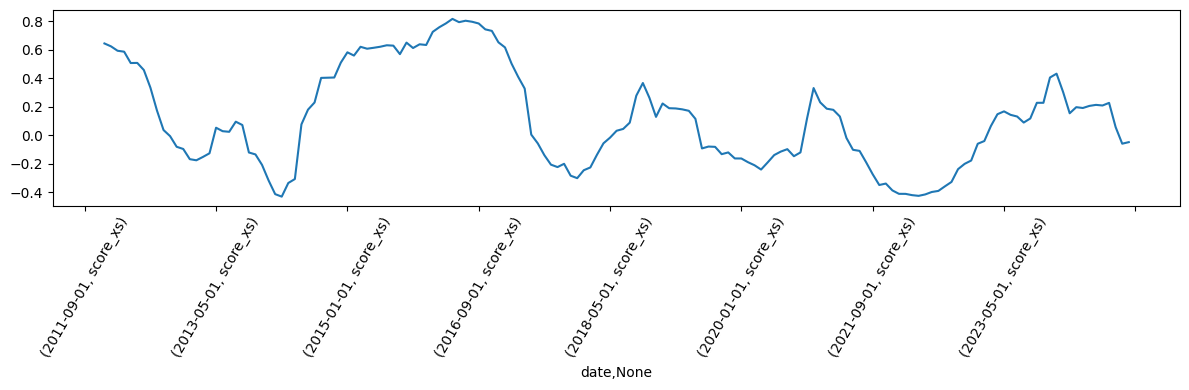

In [8]:
plt.figure(figsize=(12, 4))
rolling_ic.plot()
plt.xticks(rotation=60)
plt.tight_layout()
plt.show()


The affordability signal exhibits stable time-series variation and a
meaningful negative correlation with 12-month forward returns in Austin,
consistent with pro-cyclical housing dynamics.


In [12]:
# === Step 1: Rolling IC summary statistics ===

ic_series = rolling_ic.dropna()

ic_summary = {
    "mean_ic": ic_series.mean(),
    "std_ic": ic_series.std(),
    "positive_ratio": (ic_series > 0).mean(),
    "n_obs": ic_series.shape[0],
}

ic_summary

{'mean_ic': np.float64(0.121208056992779),
 'std_ic': np.float64(0.3454155384880728),
 'positive_ratio': np.float64(0.5732484076433121),
 'n_obs': 157}

In [14]:
import numpy as np
import pandas as pd

# Create a working copy of the dataset
d = df.copy()

# Keep only observations with valid signal and forward return
# Sort by time for consistency
d = d.dropna(subset=["score_xs", "fwd_return"]).sort_values("date")

# Define market regimes based on the sign of 12-month forward return
# "up" regime: positive future return
# "down" regime: negative future return
d["regime"] = np.where(d["fwd_return"] >= 0, "up", "down")

# Define a function to compute regime-level statistics
def regime_ic(g):
    return pd.Series({
        # Number of observations in this regime
        "n": len(g),

        # Information Coefficient between signal and forward return
        "ic": g["score_xs"].corr(g["fwd_return"]),

        # Average forward return in this regime
        "mean_fwd_return": g["fwd_return"].mean(),
    })

# Apply the IC computation separately within each regime
out = d.groupby("regime").apply(regime_ic)

out


/var/folders/dg/2kv5bj0j5d9c8wklbylhzg800000gn/T/ipykernel_95968/1945538813.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = d.groupby("regime").apply(regime_ic)


,n,ic,mean_fwd_return
regime,,,
down,74.0,-0.434744,-0.041457
up,106.0,0.075702,0.043841
